In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

from torchview import draw_graph
from IPython.display import display, HTML

from common import h5dataset, model_dnn, onnxexporter, trainer_gan_trajectory


class Critic(nn.Module):
    def __init__(
        self,
        name: str,
        hidden_size: list,
        output_size: int,
        feature_dim: int = 72,
        action_dim: int = 9,
        num_items: int = 36,   # cards/slots per state
    ):
        super().__init__()
        self.name = f"{name}_{'_'.join(map(str, hidden_size))}_dnn"
        self.feature_dim = feature_dim
        self.action_dim = action_dim
        self.num_items = num_items
        self.output_size = output_size

        dim_in = feature_dim + action_dim
        layers = []
        for h in hidden_size:
            layers.append(nn.Linear(dim_in, h))
            layers.append(nn.ReLU())
            dim_in = h
        layers.append(nn.Linear(dim_in, output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        """
        state:  [B, 36, 72]
        action: [B, 36, 9]
        returns: [B, 36, output_size]  (squeezed to [B, 36] if output_size == 1)
        """
        B, N, F = state.shape
        assert N == self.num_items and F == self.feature_dim, \
            f"state expected [B,{self.num_items},{self.feature_dim}], got {state.shape}"
        Ba, Na, A = action.shape
        assert Ba == B and Na == N and A == self.action_dim, \
            f"action expected [B,{N},{self.action_dim}], got {action.shape}"

        x = torch.cat([state, action], dim=-1)     # [B, N, F+A]
        x = x.view(B * N, F + A)                   # flatten per item
        x = self.layers(x)                         # [B*N, output_size]
        x = x.view(B, N, self.output_size)         # restore [B, N, output_size]

        if self.output_size == 1:
            x = x.squeeze(-1)                      # [B, N]
        return x


    

In [2]:
# Plot model graph
gen = model_dnn.ModelDNN(
    name="JassGanGen",
    input_size=72,
    embedding_size=13,
    hidden_size=[512, 256, 128],
    output_size=9,
)
gen_graph = draw_graph(gen, torch.zeros(1, 72).long(), show_shapes=True)

critic = Critic(
    name="JassGanCritic",
    hidden_size=[1024, 512, 256, 128],
    output_size=1
)
# The discriminator expects a tensor of shape [B, 36, 73]

critic_graph = draw_graph(critic, (torch.zeros(1, 36, 72), torch.zeros(1, 36, 9)), show_shapes=True)

gen_svg = gen_graph.visual_graph.pipe(format="svg").decode("utf-8")
critic_svg = critic_graph.visual_graph.pipe(format="svg").decode("utf-8")

display(HTML(
    f"""
    <div style="display: flex; flex-direction: row; gap: 40px;">
        <div>{gen_svg}</div>
        <div>{critic_svg}</div>
    </div>
    """
))

In [3]:
DATASET_PATH = '../log_parser/dataset/flat_trajectory_playing.hdf5'
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}")

MODLE_PATH = './models/play_gan_trajectory'
if not os.path.exists(MODLE_PATH):
    os.makedirs(MODLE_PATH)

LOGS_PATH = './logs/play_gan_trajectory'
if not os.path.exists(LOGS_PATH):
    os.makedirs(LOGS_PATH)

TRUMP_MODLE_PATH = './models/trump/JassTrump_128_64_dnn.pth'
if not os.path.exists(TRUMP_MODLE_PATH):
    raise FileNotFoundError(f"Trump model not found at {TRUMP_MODLE_PATH}")

trump_model = model_dnn.ModelDNN(
    name="JassTrump",
    input_size=10,
    embedding_size=13,
    hidden_size=[128, 64],
    output_size=7,
)
trump_model.load_state_dict(torch.load(TRUMP_MODLE_PATH))
trump_model.eval()

ModelDNN(
  (embedding): Embedding(37, 13)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=130, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [4]:

BATCH_SIZE = 256
NUM_EPOCHS = 15
LEARNING_RATE = 1e-4
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
dataset = h5dataset.H5Dataset(DATASET_PATH)
train_dataset, val_dataset = dataset.split(0.8)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

trump_model = trump_model.to(device)
gen = gen.to(device)
optimizer = optim.Adam(gen.parameters(), lr=LEARNING_RATE)
critic = critic.to(device)
disc_optimizer = optim.Adam(critic.parameters(), lr=LEARNING_RATE)
accuracy_fn = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).float().mean()

# set up trainer
trainer = trainer_gan_trajectory.TrainerGanTrajectory(
    train_loader=train_loader,
    val_loader=val_loader,
    model_path=MODLE_PATH,
    device=device
)

Using device: cuda


In [5]:
# train the model
trainer.train(NUM_EPOCHS, critic, gen, trump_model, optimizer, disc_optimizer)
torch.save(gen.state_dict(), f"{MODLE_PATH}/{gen.name}.pth")
torch.save(critic.state_dict(), f"{MODLE_PATH}/{critic.name}.pth")

Training Epoch 1:   0%|          | 0/1863 [00:00<?, ?it/s]c:\Users\sollb\Documents\fhnw\ip5\IP5-Jass-AI\training\.venv\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training Epoch 1: 100%|██████████| 1863/1863 [10:47<00:00,  2.88it/s]


Generator steps: 800, Discriminator steps: 1063


Validation Epoch 1: 100%|██████████| 466/466 [02:42<00:00,  2.87it/s]


Epoch 1/15 - Generator Train Loss: 1.6256, Discriminator Train Loss: -0.5934, Generator Val Loss: 2.5991, Discriminator Val Loss: -1.9113


Training Epoch 2: 100%|██████████| 1863/1863 [11:29<00:00,  2.70it/s]


Generator steps: 666, Discriminator steps: 1197


Validation Epoch 2: 100%|██████████| 466/466 [02:34<00:00,  3.01it/s]


Epoch 2/15 - Generator Train Loss: 2.2144, Discriminator Train Loss: -1.8268, Generator Val Loss: 2.0586, Discriminator Val Loss: -1.9682


Training Epoch 3: 100%|██████████| 1863/1863 [10:39<00:00,  2.91it/s]


Generator steps: 641, Discriminator steps: 1222


Validation Epoch 3: 100%|██████████| 466/466 [02:35<00:00,  2.99it/s]


Epoch 3/15 - Generator Train Loss: 2.1865, Discriminator Train Loss: -1.8567, Generator Val Loss: 2.0981, Discriminator Val Loss: -1.9884


Training Epoch 4: 100%|██████████| 1863/1863 [10:56<00:00,  2.84it/s]


Generator steps: 607, Discriminator steps: 1256


Validation Epoch 4: 100%|██████████| 466/466 [02:38<00:00,  2.93it/s]


Epoch 4/15 - Generator Train Loss: 2.2337, Discriminator Train Loss: -1.8763, Generator Val Loss: 2.5317, Discriminator Val Loss: -1.9934


Training Epoch 5: 100%|██████████| 1863/1863 [10:48<00:00,  2.87it/s]


Generator steps: 611, Discriminator steps: 1252


Validation Epoch 5: 100%|██████████| 466/466 [03:02<00:00,  2.55it/s]


Epoch 5/15 - Generator Train Loss: 2.2901, Discriminator Train Loss: -1.8902, Generator Val Loss: 2.0166, Discriminator Val Loss: -2.0400


Training Epoch 6: 100%|██████████| 1863/1863 [10:32<00:00,  2.94it/s]


Generator steps: 555, Discriminator steps: 1308


Validation Epoch 6: 100%|██████████| 466/466 [03:02<00:00,  2.56it/s]


Epoch 6/15 - Generator Train Loss: 2.3296, Discriminator Train Loss: -1.9030, Generator Val Loss: 1.8962, Discriminator Val Loss: -2.0265


Training Epoch 7: 100%|██████████| 1863/1863 [10:32<00:00,  2.95it/s]


Generator steps: 588, Discriminator steps: 1275


Validation Epoch 7: 100%|██████████| 466/466 [03:03<00:00,  2.55it/s]


Epoch 7/15 - Generator Train Loss: 2.3454, Discriminator Train Loss: -1.9069, Generator Val Loss: 2.5666, Discriminator Val Loss: -2.0418


Training Epoch 8: 100%|██████████| 1863/1863 [10:33<00:00,  2.94it/s]


Generator steps: 528, Discriminator steps: 1335


Validation Epoch 8: 100%|██████████| 466/466 [03:00<00:00,  2.59it/s]


Epoch 8/15 - Generator Train Loss: 2.4269, Discriminator Train Loss: -1.9196, Generator Val Loss: 2.3156, Discriminator Val Loss: -2.0328


Training Epoch 9: 100%|██████████| 1863/1863 [10:32<00:00,  2.95it/s]


Generator steps: 552, Discriminator steps: 1311


Validation Epoch 9: 100%|██████████| 466/466 [03:01<00:00,  2.57it/s]


Epoch 9/15 - Generator Train Loss: 2.5098, Discriminator Train Loss: -1.9229, Generator Val Loss: 2.7196, Discriminator Val Loss: -2.0324


Training Epoch 10: 100%|██████████| 1863/1863 [10:34<00:00,  2.94it/s]


Generator steps: 523, Discriminator steps: 1340


Validation Epoch 10: 100%|██████████| 466/466 [03:01<00:00,  2.57it/s]


Epoch 10/15 - Generator Train Loss: 2.5943, Discriminator Train Loss: -1.9241, Generator Val Loss: 2.2257, Discriminator Val Loss: -2.0414


Training Epoch 11: 100%|██████████| 1863/1863 [10:34<00:00,  2.94it/s]


Generator steps: 471, Discriminator steps: 1392


Validation Epoch 11: 100%|██████████| 466/466 [03:04<00:00,  2.52it/s]


Epoch 11/15 - Generator Train Loss: 2.5804, Discriminator Train Loss: -1.9317, Generator Val Loss: 2.3679, Discriminator Val Loss: -2.0810


Training Epoch 12: 100%|██████████| 1863/1863 [10:34<00:00,  2.94it/s]


Generator steps: 509, Discriminator steps: 1354


Validation Epoch 12: 100%|██████████| 466/466 [03:02<00:00,  2.56it/s]


Epoch 12/15 - Generator Train Loss: 2.5835, Discriminator Train Loss: -1.9306, Generator Val Loss: 2.6279, Discriminator Val Loss: -2.0747


Training Epoch 13: 100%|██████████| 1863/1863 [10:35<00:00,  2.93it/s]


Generator steps: 521, Discriminator steps: 1342


Validation Epoch 13: 100%|██████████| 466/466 [02:38<00:00,  2.94it/s]


Epoch 13/15 - Generator Train Loss: 2.5005, Discriminator Train Loss: -1.9325, Generator Val Loss: 2.4995, Discriminator Val Loss: -2.0706


Training Epoch 14: 100%|██████████| 1863/1863 [10:29<00:00,  2.96it/s]


Generator steps: 489, Discriminator steps: 1374


Validation Epoch 14: 100%|██████████| 466/466 [02:36<00:00,  2.98it/s]


Epoch 14/15 - Generator Train Loss: 2.5136, Discriminator Train Loss: -1.9377, Generator Val Loss: 2.6840, Discriminator Val Loss: -2.0181


Training Epoch 15: 100%|██████████| 1863/1863 [10:54<00:00,  2.85it/s]


Generator steps: 495, Discriminator steps: 1368


Validation Epoch 15: 100%|██████████| 466/466 [02:36<00:00,  2.97it/s]

Epoch 15/15 - Generator Train Loss: 2.5463, Discriminator Train Loss: -1.9478, Generator Val Loss: 2.5110, Discriminator Val Loss: -2.0233


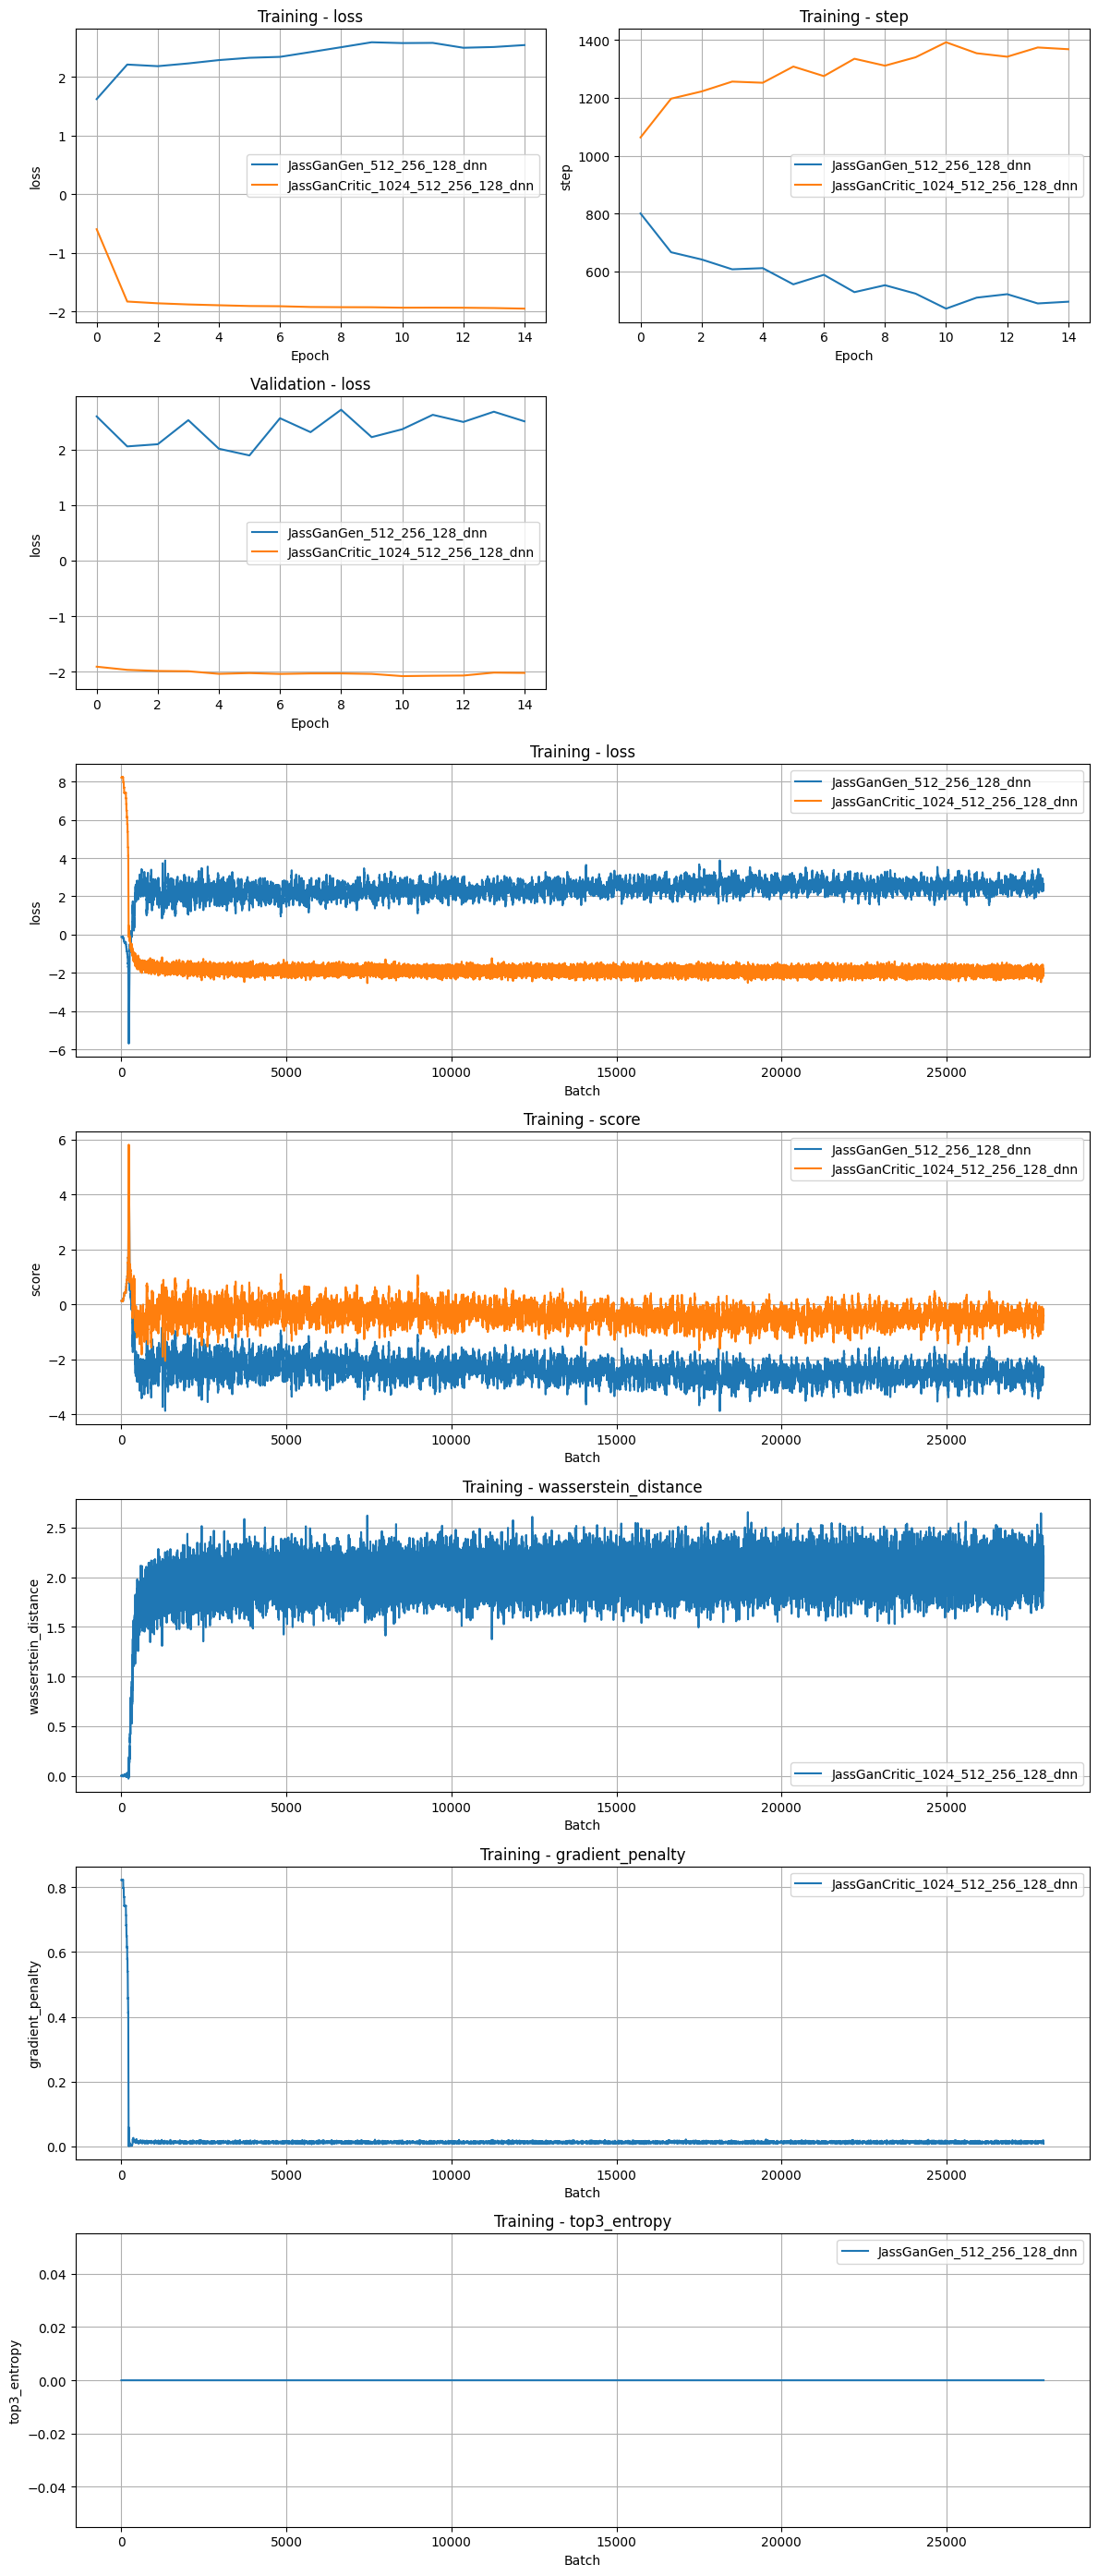

In [6]:
# create graphs
trainer.monitor.plot()

In [7]:
trainer.monitor.dump(dump_path=LOGS_PATH, filename="monitor")

In [ ]:
# export the model to ONNX
ONNX_PATH = f"{MODLE_PATH}/{model.name}.onnx"
model = model_dnn.ModelDNN(
    name="JassGanGen",
    input_size=72,
    embedding_size=13,
    hidden_size=[1024, 512, 256, 128],
    output_size=9,
)
model.load_state_dict(torch.load(f"{MODLE_PATH}/{model.name}.pth"))
onnxexporter.onnx_exporter(
    model=model,
    decision_fn=F.log_softmax,
    in_dim=72,
    output_path=ONNX_PATH
)